# 0100 ベースラインモデル構築と評価
1. 多重共線性への対処：面積関連変数/フラグや古さ指標など、相関の高い変数が多いため、正則化モデルが適切
2. 解釈のしやすさ：線形モデルはモデルの解釈がしやすい。どの特徴量が重要かが係数から分かる
3. 計算効率：非線形モデルに比べて学習が速いから、素早く結果を確認できる
4. 過学習の防止：正則化パラメータを調整することで、過学習を防げる

以上の利用から、Ridge回帰をベースラインモデルとして選定。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pingouin as pg

from constants import *

plt.style.use('ggplot')
sns.set_palette('rocket')

## 0. データ取得から標準化まで

In [2]:
all_data = pd.read_csv(os.path.join(RAW_PATH, '0000_train.csv'), index_col=0)
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,has_bsmt,has_garage,has_pool,has_central_ac,log_total_sf,log_lot_area,house_age,remod_age,built_era,year_price
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,1,1,0,1,7.850104,9.042040,5,5,post-2000,227387.363668
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,1,1,0,1,7.833600,9.169623,31,31,60-80,166794.831439
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,1,1,0,1,7.903227,9.328212,7,6,post-2000,223657.905932
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,1,1,0,1,7.813187,9.164401,91,36,1900-1940,124018.557143
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,1,1,0,1,8.114624,9.565284,8,8,80-2000,222266.190377


### 訓練と検証に使用するデータを作成
#### 作成した特徴量を抽出

In [3]:
features = [
    'log_total_sf', 'log_lot_area', 'house_age', 'remod_age',
    'year_price', 'GarageCars', 'MSSubClass_weight', 'MSZoning_weight', 
    'neighbor_weight', 'has_2nd', 'has_bsmt', 'has_garage', 'has_pool', 'has_central_ac',
    'OverallQual_weight', 'OverallCond_weight', 'ExterQual_weight', 'ExterCond_weight',
    'BsmtQual_weight', 'BsmtCond_weight',  'KitchenQual_weight', 'Utilities_weight',
    'GarageQual_weight', 'GarageCond_weight', 'PoolQC_weight', 'Functional_weight'
    ]

# 説明変数
data = all_data[features]

# 目的変数
target = all_data['log_price']

#### 訓練データとテストデータに分割

In [4]:
X = data
y = target

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=87)


フラグと、すでに標準化されているものを除いて標準化

In [5]:
# 標準化する変数
cols_to_scale = [
    'log_total_sf', 'log_lot_area', 'GarageCars',
    'house_age', 'remod_age', 'year_price'
    ] 

# 標準化しない変数
cols_not_scale = [
    'MSSubClass_weight', 'MSZoning_weight', 'neighbor_weight' ,
    'has_2nd', 'has_bsmt', 'has_garage', 'has_pool', 'has_central_ac'
    'OverallQual_weight', 'OverallCond_weight', 'ExterQual_weight', 'ExterCond_weight',
    'BsmtQual_weight', 'BsmtCond_weight',  'KitchenQual_weight', 'Utilities_weight',
    'GarageQual_weight', 'GarageCond_weight', 'PoolQC_weight', 'Functional_weight'
    ]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# 標準化を実行
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_val[cols_to_scale] = scaler.transform(X_val[cols_to_scale])

## 1. モデル構築：Ridge回帰

### Ridge回帰モデルで学習
$\alpha=0$（単純な線形モデル）<br>
スコアは対数価格についてのRMSE<br>
参考に決定係数$R^2$

In [6]:
from sklearn.linear_model import Ridge

alpha = 0 # 正則化パラメータはいったん0

# インスタンスを生成
test_model = Ridge(alpha=alpha, random_state=0)

# 学習
test_model.fit(X_train, y_train)

# 予測を実行
y_pred = test_model.predict(X_val)

# 評価
from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Ridge Regr. (alpha={alpha})")
print(f'  RMSE:\t{rmse:.4f}')
print(f'  R2:\t{r2:.4f}')

Ridge Regr. (alpha=0)
  RMSE:	0.1426
  R2:	0.8848


### 当てはまり度合いを確認
予測と実測の散布図、回帰線（信頼区間95%）を表示

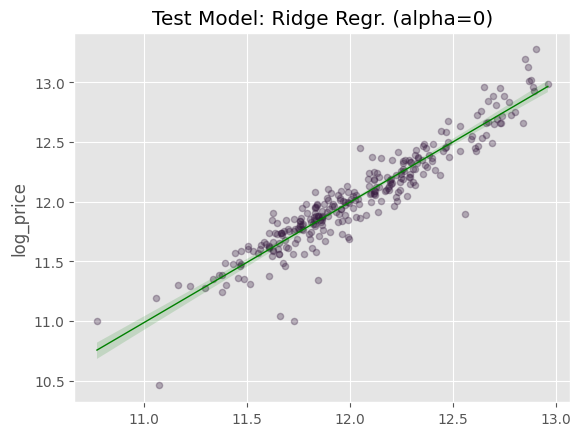

In [7]:
sns.regplot(x=y_pred, y=y_val,
            scatter_kws={'s': 20, 'alpha': 0.3},
            line_kws={'color': 'green', 'lw': 1},
            ci=95)
plt.title(f"Test Model: Ridge Regr. (alpha={alpha})")
plt.savefig(os.path.join(IMAGE_PATH, '0100_test_ridge.png'))
plt.show()


## 2. モデル評価
### 特徴量の貢献度を可視化

/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/notebooks/utils/utils.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette=colors)


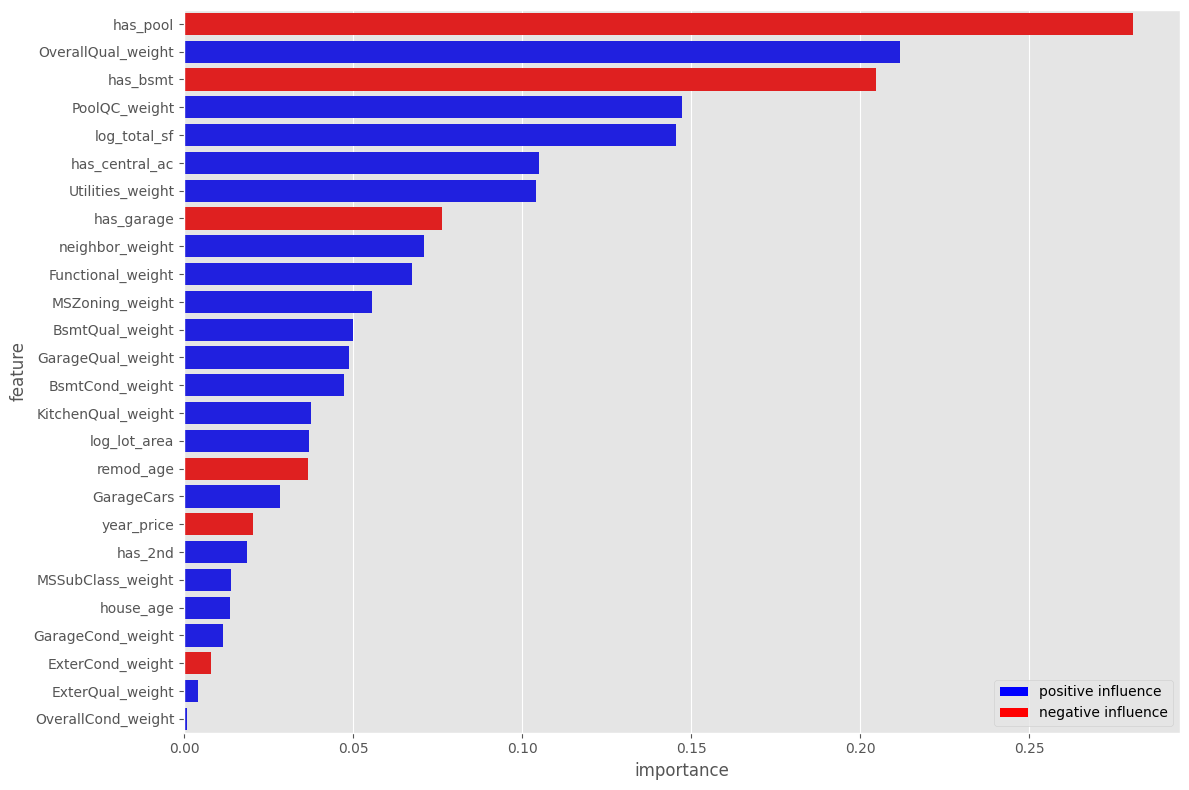

In [8]:
from utils import plot_feature_importance

# 重要度プロット呼び出し
importance_df = plot_feature_importance(test_model, features, 'coef', "Importance of Features: Ridge Regr.")
plt.savefig(os.path.join(IMAGE_PATH, '0101_feature_importance.png'))
plt.show()

In [9]:
importance_df

,feature,importance,coefficient
0,has_pool,0.280624,-0.280624
1,OverallQual_weight,0.211681,0.211681
2,has_bsmt,0.204752,-0.204752
3,PoolQC_weight,0.147296,0.147296
4,log_total_sf,0.145404,0.145404
5,has_central_ac,0.105136,0.105136
6,Utilities_weight,0.104186,0.104186
7,has_garage,0.076421,-0.076421
8,neighbor_weight,0.070981,0.070981
9,Functional_weight,0.067538,0.067538


### 貢献度からわかること
- 品質、床面積あたりが特に重要
- 負の貢献をしている意外な変数がある（プール、地下室、ガレージの有無、年代別ロール平均など）

### 今後の対応
1. 前回の特徴量作成時に、BsmtQual_WeightやPoolQC_weightなどの変数の欠損値に対し、それらは設備がないことを示していることがわかったため'NONE'で補填した。これらの情報がhas_bsmtやhas_poolなどの持つ情報と被るため、フラグを削除していく。
2. 似通った変数がある（〇〇Condと〇〇Qual系）ので、それらの相関を調べ、必要に応じてまとめる。

In [10]:
# 1.不要なカラムを削除
X_train_dropped = X_train.drop(columns=['has_pool', 'has_bsmt', 'has_garage'])
X_val_dropped = X_val.drop(columns=['has_pool', 'has_bsmt', 'has_garage'])

In [11]:
# 2. 似通った変数同士の相関を調べる: 順序尺度同士の独立性をカイ二乗検定（有意水準0.01）

sim_cols_headers = ['Overall', 'Exter', 'Garage', 'Bsmt']
sim_cols_footers = ['Cond_weight', 'Qual_weight']

from scipy.stats import chi2_contingency

for i, h in enumerate(sim_cols_headers):
    
    x = h + sim_cols_footers[0]
    y = h + sim_cols_footers[1]
    
    cross_tab = pd.crosstab(X_train_dropped[x], X_train_dropped[y])
    
    chi2, p, _, _ =chi2_contingency(cross_tab)
    
    if p < 0.01:
        print(f'"{h}" correlated / p = {round(p, 4)} < 0.01')
    else:
        print(f'"{h}" not correlated / p = {round(p, 4)} > 0.01')

"Overall" correlated / p = 0.0 < 0.01
"Exter" correlated / p = 0.0 < 0.01
"Garage" correlated / p = 0.0 < 0.01
"Bsmt" correlated / p = 0.0 < 0.01


### 品質系は連関あり、再度学習

In [12]:
test_model2 = Ridge(alpha=alpha, random_state=1)
test_model2.fit(X_train_dropped, y_train)

y_pred2 = test_model2.predict(X_val_dropped)

rmse = root_mean_squared_error(y_val, y_pred2)
r2 = r2_score(y_val, y_pred2)

print(f"Ridge Regr. (alpha={alpha})")
print(f"RMSE: {rmse:.3f}, R2: {r2:.3f}")

Ridge Regr. (alpha=0)
RMSE: 0.145, R2: 0.881


/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/notebooks/utils/utils.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette=colors)


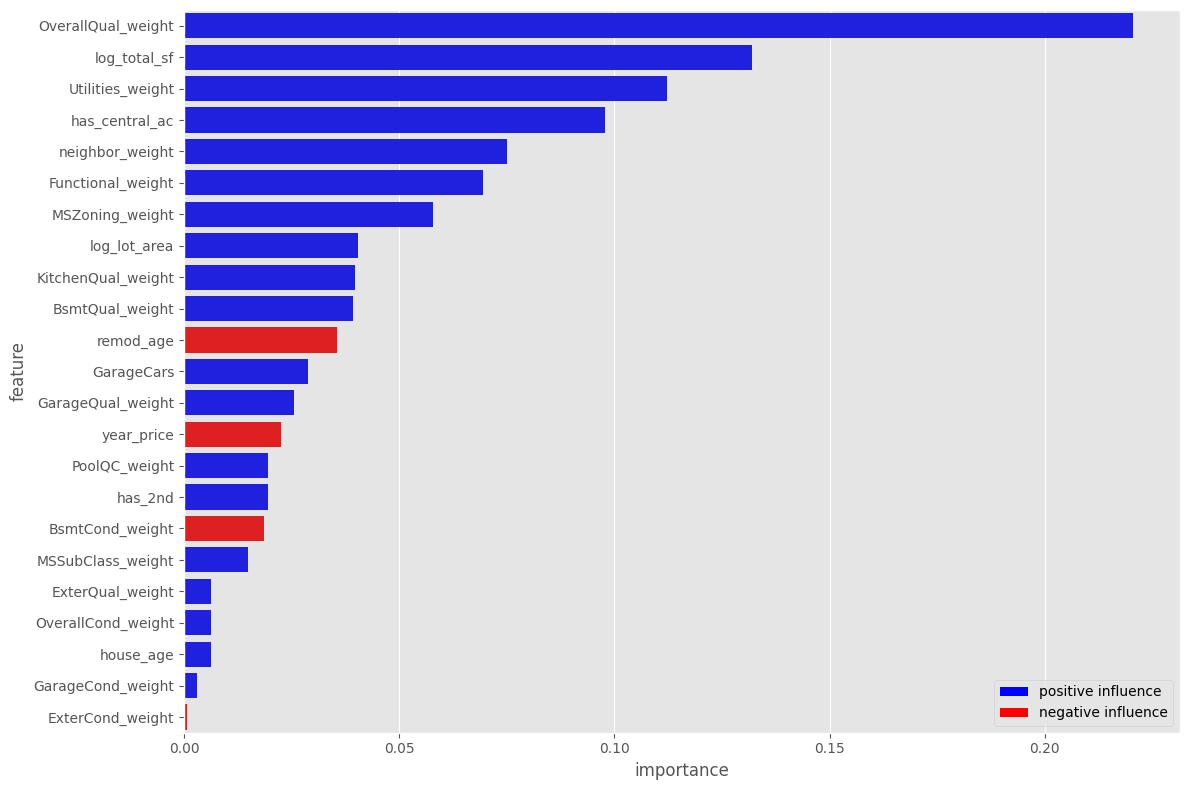

In [13]:
# 重要度プロット呼び出し
importance_df = plot_feature_importance(test_model2, X_train_dropped.columns, 'coef', "Importance of Features: Ridge Regr.")
plt.savefig(os.path.join(IMAGE_PATH, '0102_feature_importance.png'))
plt.show()


### 貢献度の高い変数順に、相関行列と偏相関行列を作成

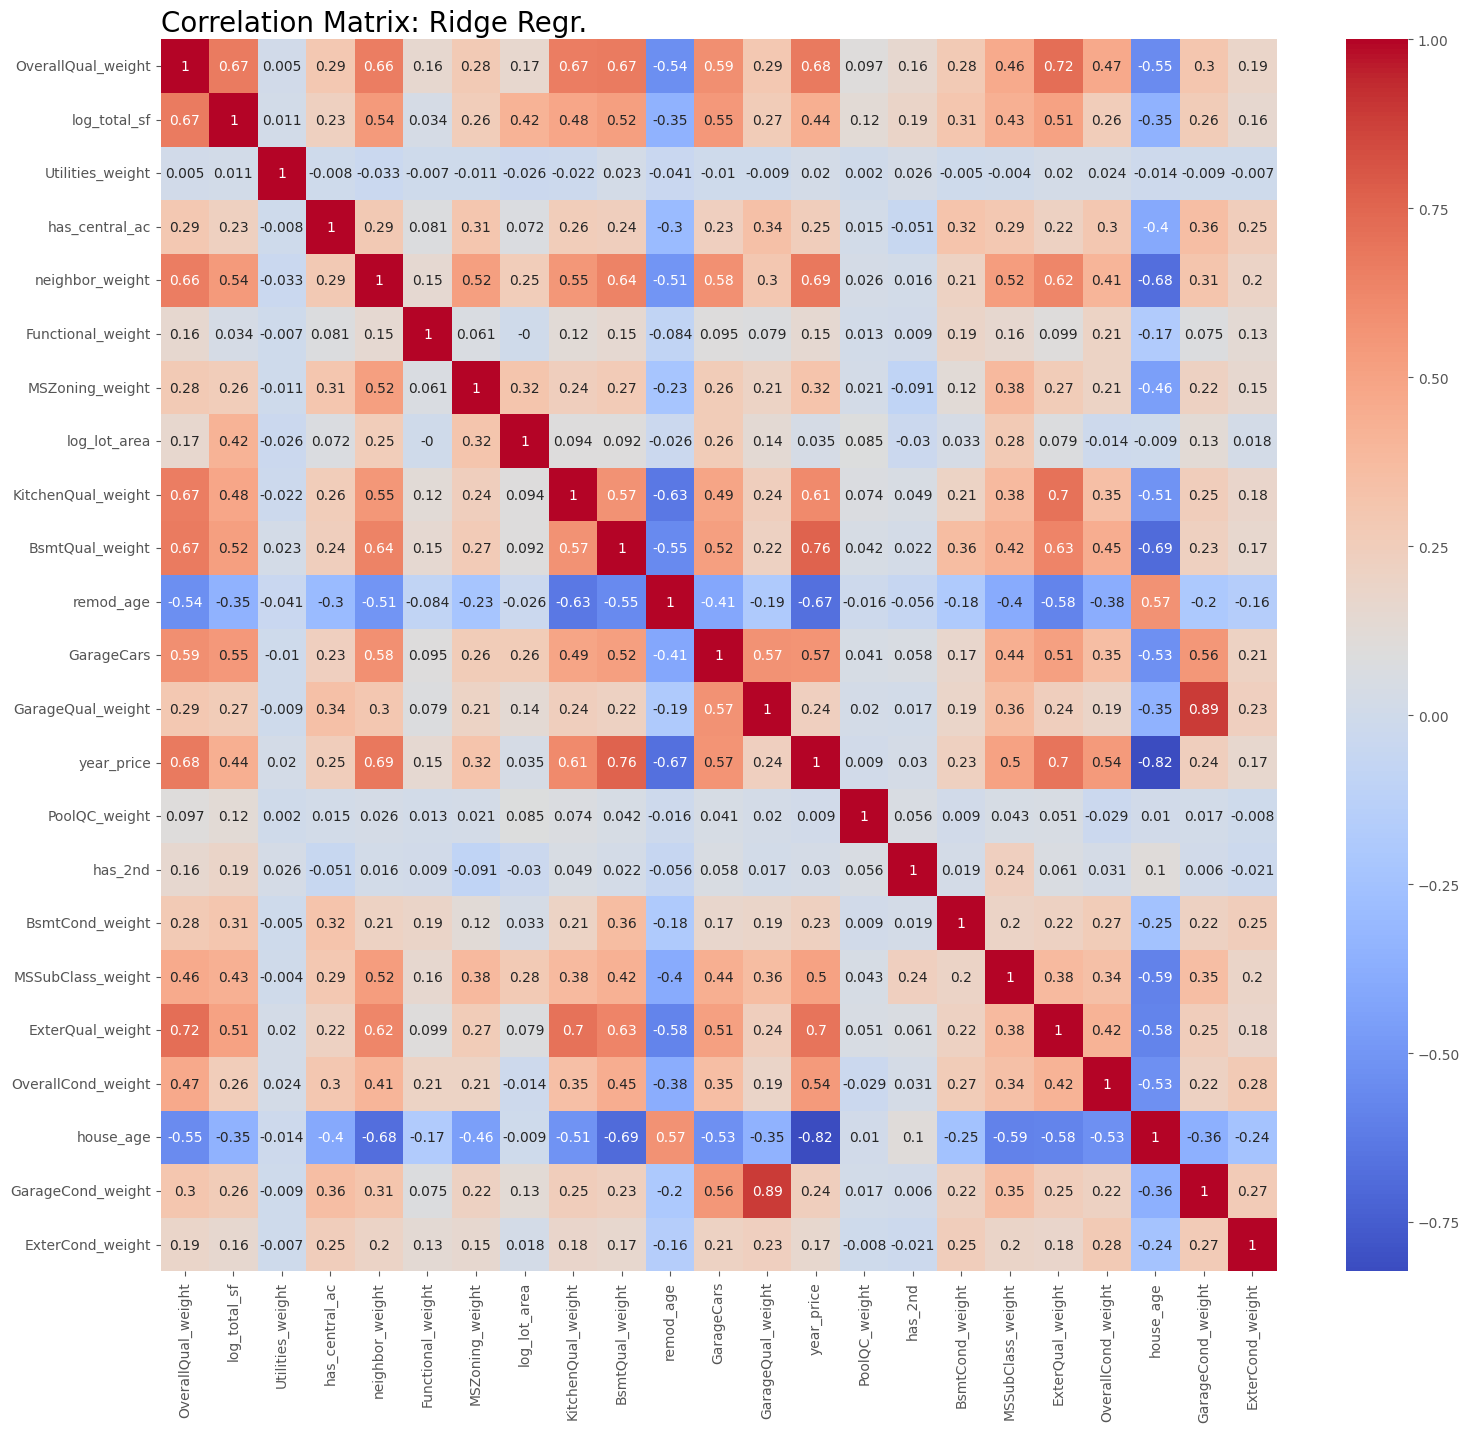

In [14]:
important_cols = importance_df['feature'].values

corr_mat = X_train_dropped[important_cols].corr().round(3)

plt.figure(figsize=(18, 16))
sns.heatmap(data=corr_mat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: Ridge Regr.', fontsize=20, loc='left')
plt.savefig(os.path.join(IMAGE_PATH, '0103_corr_matrix.png'))
plt.show()

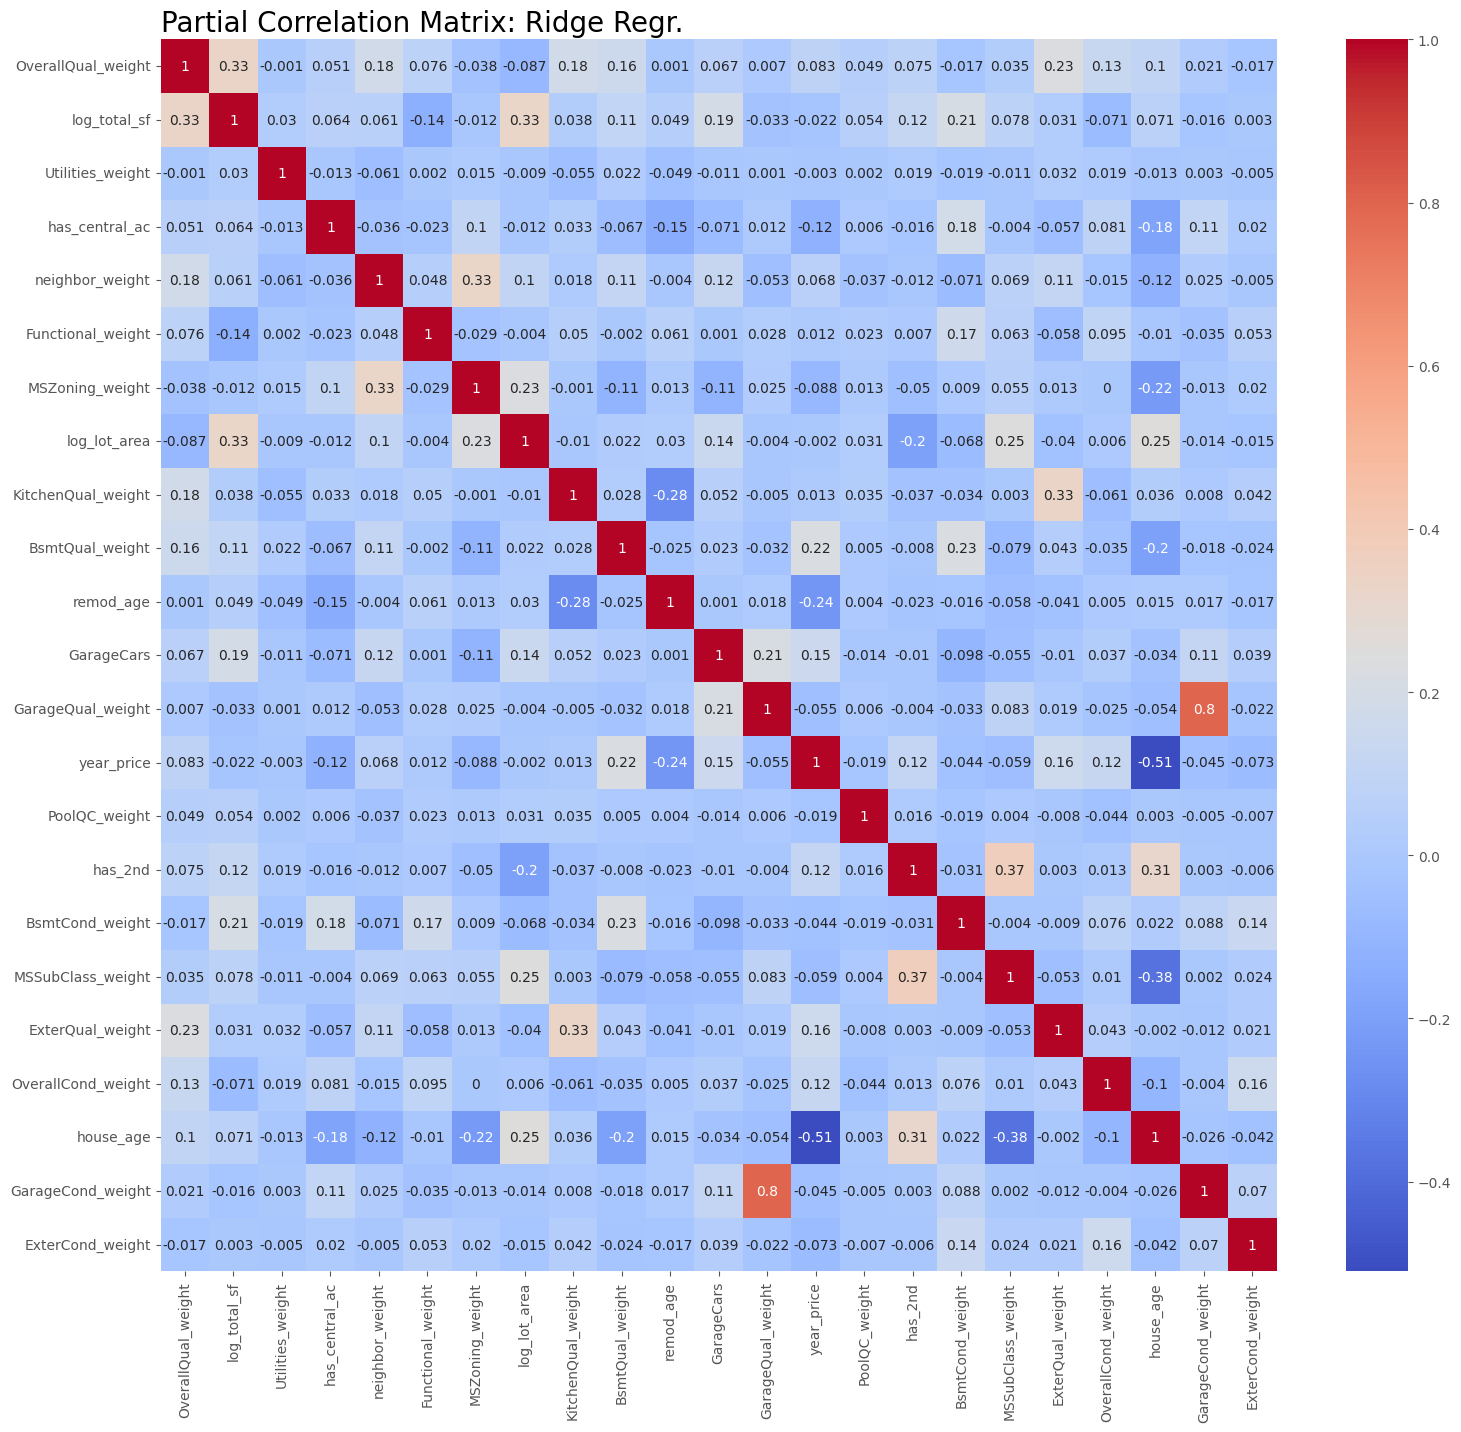

In [15]:
pcorr_mat = pg.pcorr(data[important_cols]).round(3)

plt.figure(figsize=(18, 16))
sns.heatmap(data=pcorr_mat, annot=True, cmap='coolwarm')
plt.title('Partial Correlation Matrix: Ridge Regr.', fontsize=20, loc='left')
plt.savefig(os.path.join(IMAGE_PATH, '0104_pcorr_matrix.png'))
plt.show()

### 相関図・編相関図から考えられること
- 相関も偏相関も高い：それらについてはまとめる
- 相関も偏相関も低い：独立と仮定

#### より具体的に
- 「全体の品質」と「広さ」には本質的な関係がありそう（相関・偏相関ともにある程度ある）
- ガレージのConditionとQualityについては非常に強い相関があるため、加算してまとめる
- house_ageとyear_priceについては、より強い重要度をもつyear_priceのみで進めてみる（house_ageは他の変数とも比較的相関が高い）。

#### 次のステップ：
- 広さと品質は立地（高級住宅街など）が説明しているのでは？

In [16]:
quality = X_train_dropped['OverallQual_weight']
size = X_train_dropped['log_total_sf']
location = X_train_dropped['neighbor_weight'] 

# 通常の相関（立地の効果を考慮しない）
corr_qs = np.corrcoef(quality, size)[0, 1]
print(f"品質と広さの相関: {corr_qs:.4f}")

# 部分相関（立地の効果を制御）
pcorr_qs_given_l = pg.partial_corr(data=X_train_dropped, x='OverallQual_weight', y='log_total_sf', covar='neighbor_weight')
hdi = pcorr_qs_given_l['CI95%'].iloc[0]
print(f"立地を条件とした品質と広さの部分相関（95%信頼区間）: {hdi[0]}~{hdi[1]}")

print(f'相関減少率: {((corr_qs- hdi[1])/corr_qs*100).round(2)}~{((corr_qs - hdi[0])/corr_qs*100).round(2)}%')

品質と広さの相関: 0.6693
立地を条件とした品質と広さの部分相関（95%信頼区間）: 0.45~0.53
相関減少率: 20.82~32.77%


### 解釈
品質と広さの関係の約20.8~32.8%が立地によって説明されるが、残りの7〜8割程度は立地以外の要因による本質的な関連と考えられる。

とりあえずは、第三の変数によって完全に媒介されていなさそう。

## 3. 再度学習
重複する指標と重要でない指標を削除したデータセットで、新たに学習する

In [17]:
X_train_dropped['Garage_weight'] = X_train_dropped['GarageCond_weight'] + X_train_dropped['GarageQual_weight']
X_val_dropped['Garage_weight'] = X_val_dropped['GarageCond_weight'] + X_val_dropped['GarageQual_weight']

X_train_dropped.drop(['GarageCond_weight', 'GarageQual_weight', 'house_age'], axis=1, inplace=True)
X_val_dropped.drop(['GarageCond_weight', 'GarageQual_weight', 'house_age'], axis=1, inplace=True)

In [18]:

alphas = np.logspace(-3, 5, 81)

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(
    estimator=Ridge(),
    param_grid={'alpha': alphas},
    cv=5,
    scoring='neg_root_mean_squared_error'
)

gs.fit(X_train_dropped, y_train)

best_alpha = gs.best_params_['alpha']
best_ridge = gs.best_estimator_

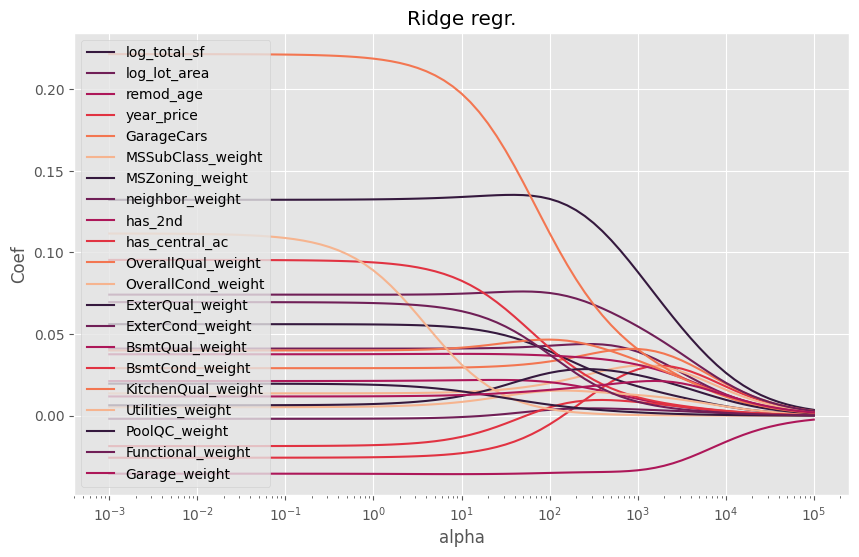

In [19]:
# 各アルファに対する係数を保存するリスト
coefs = []

# 各アルファで学習して係数を保存
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_dropped, y_train)
    coefs.append(ridge.coef_)

# 結果を配列に変換
coefs = np.array(coefs)

# 係数の変化をプロット
plt.figure(figsize=(10, 6))
for i in range(X_train_dropped.shape[1]):
    plt.plot(alphas, coefs[:, i], label=f"{X_train_dropped.columns[i]}")

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Coef')
plt.title('Ridge regr.')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig(os.path.join(IMAGE_PATH, '0105_ridge_alpha_coef.png'))
plt.show()

In [20]:
y_pred = best_ridge.predict(X_val_dropped)

rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"RMSE: {rmse:.3f}, R2: {r2:.3f}")

metrics = {
    'model': 'Ridge (base)',
    'params': f'alpha={best_alpha}',
    'RMSE': round(rmse, 4),
    'R2': round(r2, 4)
}

metrics = pd.DataFrame(metrics, index=[0])

metrics.to_csv(os.path.join(METRICS_PATH, '0100_metrics.csv'))

RMSE: 0.144, R2: 0.882


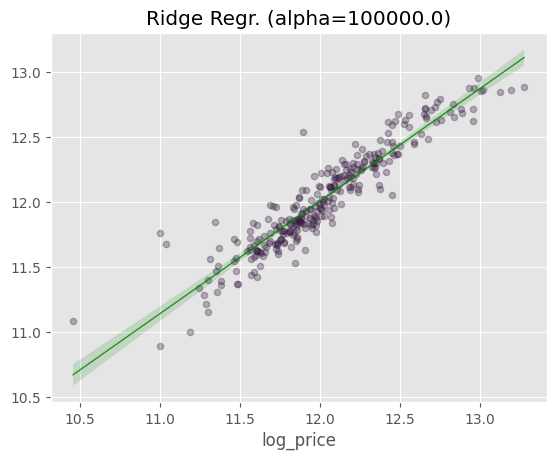

In [21]:
sns.regplot(x=y_val, y=y_pred, scatter_kws={'s': 20, 'alpha': 0.3}, line_kws={'color': 'green', 'lw': 1, 'alpha': 0.8})
plt.title(f"Ridge Regr. (alpha={alpha})")
plt.savefig(os.path.join(IMAGE_PATH, '0103_base_ridge.png'))
plt.show()

/Users/automatedtomato/github.com/automatedtomato/kaggle-house-prices/notebooks/utils/utils.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette=colors)


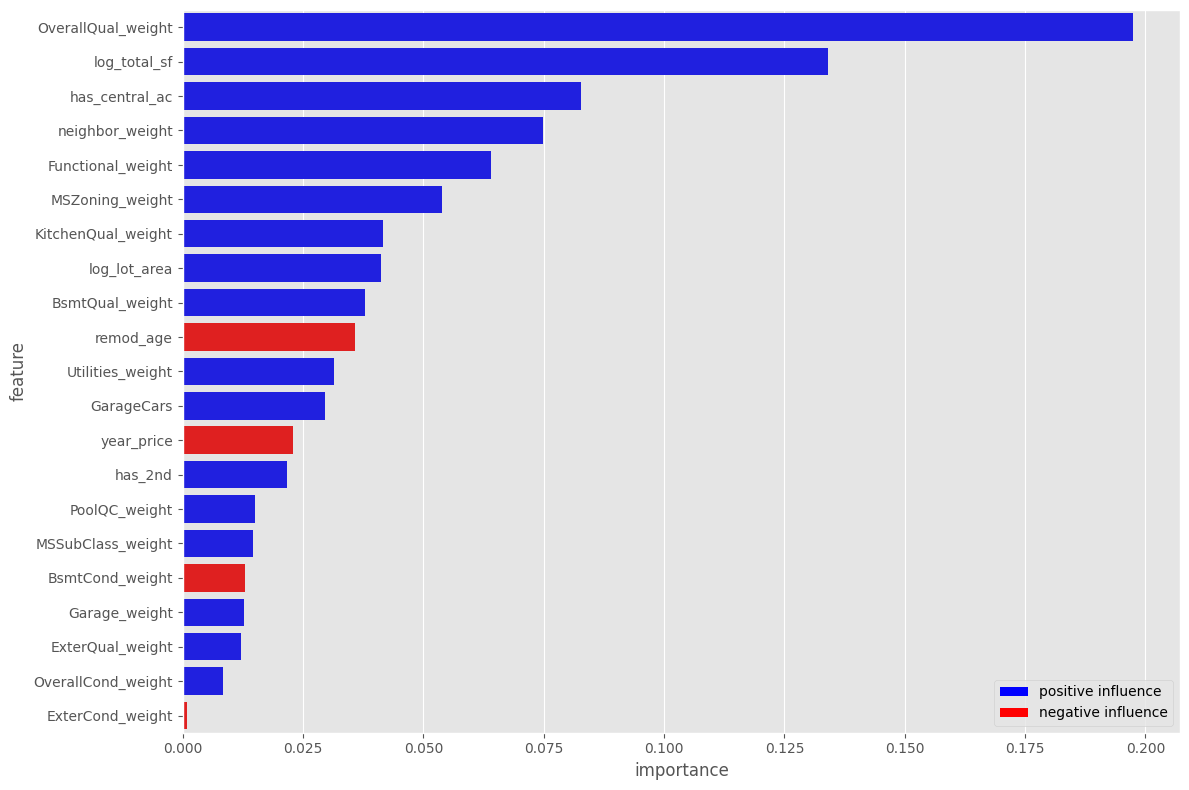

In [22]:
importance_df = plot_feature_importance(best_ridge, X_train_dropped.columns, 'coef', 'Importance of Features: Ridge Regr.')
plt.savefig(os.path.join(IMAGE_PATH, '0106_feature_importance.png'))
plt.show()

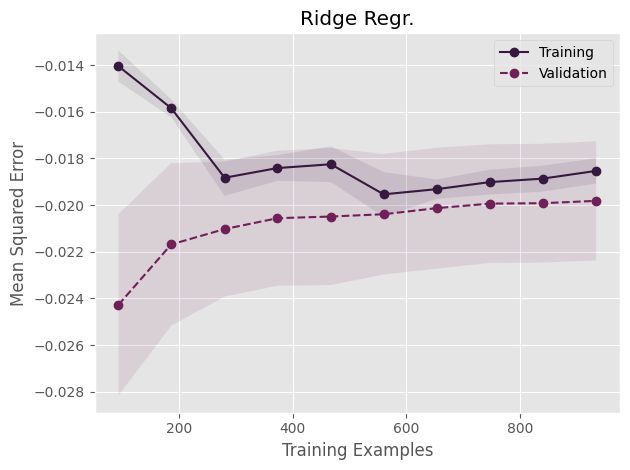

In [23]:
from utils import plot_learning_curve

plot_learning_curve(Ridge(best_alpha), X_train, y_train,'Ridge Regr.')
plt.savefig(os.path.join(IMAGE_PATH, '0107_learning_curve.png'))
plt.show()

## 4. ベースラインモデル決定
- alpha=10のRidge回帰モデル

In [24]:
X_train_dropped.columns

Index(['log_total_sf', 'log_lot_area', 'remod_age', 'year_price', 'GarageCars',
       'MSSubClass_weight', 'MSZoning_weight', 'neighbor_weight', 'has_2nd',
       'has_central_ac', 'OverallQual_weight', 'OverallCond_weight',
       'ExterQual_weight', 'ExterCond_weight', 'BsmtQual_weight',
       'BsmtCond_weight', 'KitchenQual_weight', 'Utilities_weight',
       'PoolQC_weight', 'Functional_weight', 'Garage_weight'],
      dtype='object')